In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")


import jax
import jax.numpy as jnp

from src.bandits.data import (
    batched_rewards,
    multiregime_rewards,
    stationary_rewards,
)
from src.bandits.environment import (
    Policy,
    benchmark_policies,
    simulate,
    simulate_multiple_datasets,
    simulate_multiple_iterations,
)
from src.bandits.policies import epsilon_greedy, thomson_sampling, ucb
from src.bandits.utils import plot_reward_probs, plot_rewards

# Example

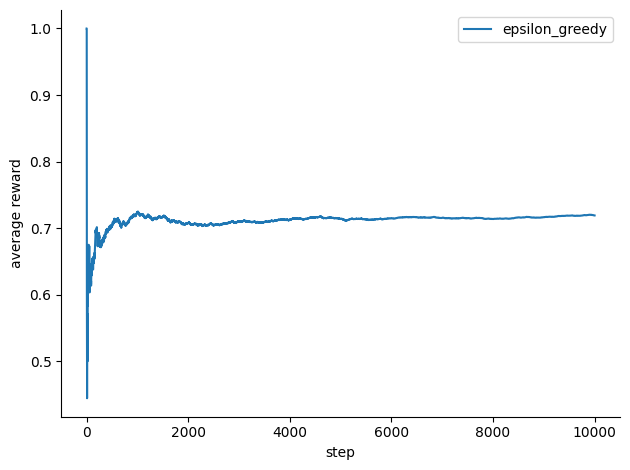

In [3]:
# single policy, one true rewards distribution, one iteration

key = jax.random.key(1234)
key_r, key_s = jax.random.split(key, 2)

num_actions = 6
num_steps = 10_000

true_rewards, _ = stationary_rewards(key_r, num_steps, num_actions)
state, rewards = simulate(
    key_s,
    true_rewards,
    epsilon_greedy.select_action,
    epsilon_greedy.update_state,
    epsilon_greedy.EpsilonGreedyState(
        epsilon=0.3,
        values=jnp.zeros(num_actions),
        counts=jnp.zeros(num_actions),
        epsilon_decay=0.99,
    ),
    num_steps,
)

plot_rewards(jnp.expand_dims(rewards, axis=(0, 1, 2)), ["epsilon_greedy"])

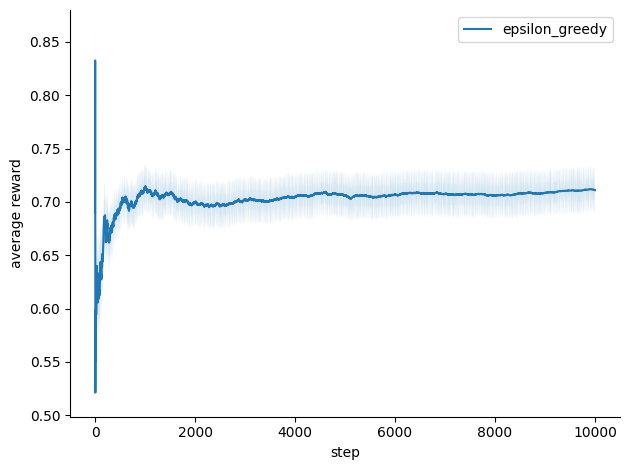

In [4]:
# multiple iterations

num_iter = 100

state, rewards = simulate_multiple_iterations(
    key_s,
    true_rewards,
    epsilon_greedy.select_action,
    epsilon_greedy.update_state,
    epsilon_greedy.EpsilonGreedyState(
        epsilon=0.3,
        values=jnp.zeros(num_actions),
        counts=jnp.zeros(num_actions),
        epsilon_decay=0.99,
    ),
    num_steps,
    num_iter,
)

plot_rewards(jnp.expand_dims(rewards, axis=(0, 1)), ["epsilon_greedy"])

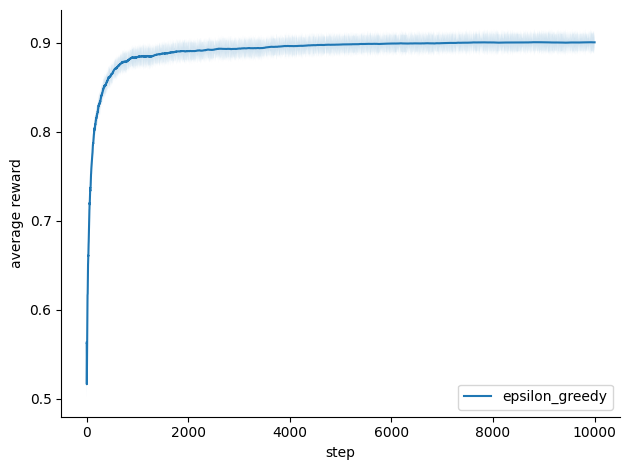

In [5]:
# multiple rewards distributions

num_datasets = 10

batched_true_rewards, _ = batched_rewards(
    key=key_r,
    dataset_generator_fn=stationary_rewards,
    dataset_generator_fn_args=(),
    num_steps=num_steps,
    num_actions=num_actions,
    num_datasets=num_datasets,
)

state, rewards = simulate_multiple_datasets(
    key_s,
    batched_true_rewards,
    epsilon_greedy.select_action,
    epsilon_greedy.update_state,
    epsilon_greedy.EpsilonGreedyState(
        epsilon=0.3,
        values=jnp.zeros(num_actions),
        counts=jnp.zeros(num_actions),
        epsilon_decay=0.99,
    ),
    num_steps,
    num_iter,
)

plot_rewards(jnp.expand_dims(rewards, axis=0), ["epsilon_greedy"])

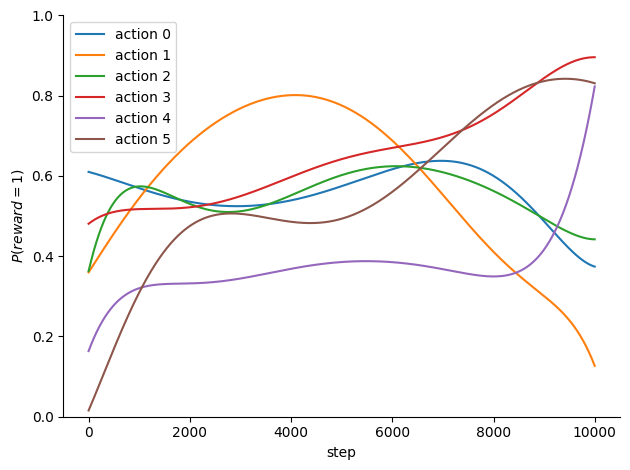

In [28]:
# non stationary rewards distribution

num_regimes = 10
_, p = multiregime_rewards(key_r, num_steps, num_actions, num_regimes)

plot_reward_probs(p)

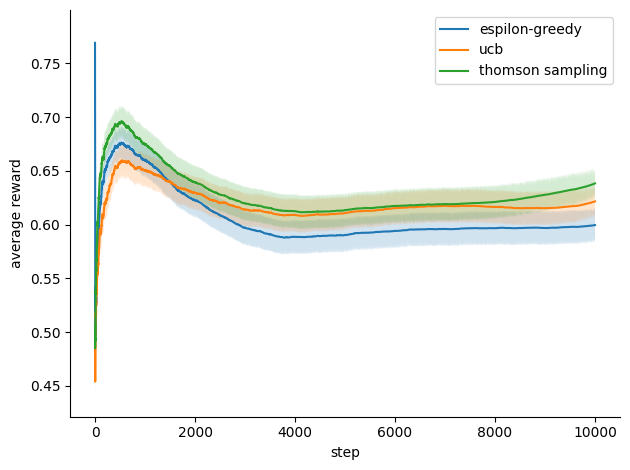

In [6]:
# multiple policies, iterations and non stationary rewards distributions

greedy_init_state = epsilon_greedy.EpsilonGreedyState(
    epsilon=0.1,
    epsilon_decay=1.0,
    values=jnp.zeros(num_actions),
    counts=jnp.zeros(num_actions),
)

ucb_init_state = ucb.UCBState(
    c=1.0,
    steps=0.0,
    values=jnp.zeros(num_actions),
    counts=jnp.zeros(num_actions),
)

ts_init_state = thomson_sampling.ThomsonSamplingState(
    alphas=jnp.ones(num_actions),
    betas=jnp.ones(num_actions),
    discount=0.999,
)

policies = [
    Policy(epsilon_greedy.select_action, epsilon_greedy.update_state, greedy_init_state),
    Policy(ucb.select_action, ucb.update_state, ucb_init_state),
    Policy(thomson_sampling.select_action, thomson_sampling.update_state, ts_init_state),
]

_, rewards = benchmark_policies(
    key,
    policies,
    num_actions,
    num_steps,
    num_iter,
    num_datasets,
    dataset_generator_fn=multiregime_rewards,
    dataset_generator_fn_args=(10,),
)

plot_rewards(rewards, ["espilon-greedy", "ucb", "thomson sampling"])